# Classifying Non Profit Donor Strategy from Cultivating Volunteers


**Sanjay Regi Philip and Maha Jayapal**

**Applied Data Science**

**Master’s Program**

**Shiley Marcos School of Engineering/ University of San Diego**

**sregiphilip@sandiego.edu | mjayapal@sandiego.edu**

### Purpose/Abstract:
The purpose of this analytical research project is to leverage non profit volunteer databases to identify individuals who are likely to be high-level donors. As fundraising is vital to supporting nonprofit organizations in serving their communities, efforts to help organizations be more efficient in their fundraising efforts can have positive impacts on many peoples’ lives.
This project examines the use of machine learning applications to assist nonprofit organizations in identifying high-level donors for fundraising efforts. 
Leveraging data from the U.S. census for a proof of concept, a classification application was successfully developed that will help organizations identify individuals who are able to provide large financial gifts .

### Business Background
As nonprofits rely on fundraising to sustain their operations, they must be able to maximize their fundraising potential in order to serve their communities. One way of maximizing fundraising potential is by identifying and asking for large gifts from high-level donors.Midlevel donors are defined as middle class individuals who are likely to provide small to medium sized donations for non profit organizatiosn. High-level donors are middle class to upper-class individuals who are able to provide larger sized financial gifts.

### Problem Statement
Nonprofit organizations need help to identify who are supporters that are high-level donors vs those who are midlevel donors, as high-level donors require higher levels of contact to stay engaged in supporting a cause.

### Data Retrieved from: 

https://archive.ics.uci.edu/ml/datasets/census+income 

### Summary of Findings
Machine Learning classification techniques are sucessfully able to to identify donor class despite large class imbalances. The best performing method using this dataset was found to be a naive bayes model with tuned hyperparameters

## Load Necessary Packages

In [1]:
# importing packages for the project
import pandas as pd
import numpy as np 
import seaborn as sns

import dmba
from dmba import classificationSummary, gainsChart, liftChart

from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

no display found. Using non-interactive Agg backend


## Data Input

In [2]:
## Remember to replace with your local filepath
census = pd.read_csv('/Users/sanjay/Library/CloudStorage/OneDrive-Personal/USD/ADS599/Data/census.csv')

In [3]:
## Verify data was read correctly
census.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
## Dimensions of Dataset before any processing
census.shape

(48842, 15)

In [5]:
## Verify datatypes of columns in dataset
census.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

## Initial Data Preparation

### Remove Unnecessary Columns
As this project uses a census dataset, features will need to be dropped that are not likely to be available for non profit organizations to use.

In [6]:
## keep copy of original dataframe in case we need to revert back later
census_original = census

In [7]:
## drop columns that are not likely to be valuable or relevant
census = census.drop(columns=['fnlwgt','education-num', 'capital-gain', 'capital-loss', 'hours-per-week',
                             'occupation', 'relationship', 'race'])

### Check for null values

In [8]:
## summing null values
census.isna().sum()

age               0
workclass         0
education         0
marital-status    0
sex               0
native-country    0
income            0
dtype: int64

The dataset seems to have no blank or null values but instead null values have later been observed denoted by '?'.

#### Impute '?' values

In [9]:
## identify records with a '?' null value
census_string = census[['workclass', 'education', 'marital-status',
                       'sex', 'native-country', 'income']]

question_counts = census_string.apply(lambda x: x.str.count('\?')).sum()
question_counts

workclass         2799
education            0
marital-status       0
sex                  0
native-country     857
income               0
dtype: int64

As the number of '?' values were relatively low compared to the length of the dataframe, we choose to drop the rows where there is a '?' value as there is no other clear way to impute the value.

In [10]:
## drop '?' values
census = census.drop(census.loc[census['workclass'] == '?'].index)
census = census.drop(census.loc[census['native-country'] == '?'].index)

In [11]:
## shape of the dataset after removing the null values
census.shape

(45232, 7)

3656 rows were dropped to account for null values

## Exploratory Data Analysis

### Univariate Analysis
Explore the properties of each individual feature

In [12]:
## descriptive stats on age
age = census['age']
age.describe()

count    45232.000000
mean        38.543819
std         13.219436
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64

array([[<AxesSubplot: title={'center': 'age'}>]], dtype=object)

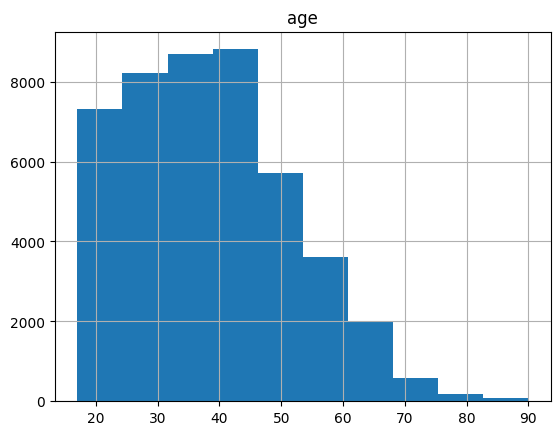

In [13]:
## historgram of age
census.hist(column='age')

This analysis shows that the individuals in the given dataset has a mean of 38.54 years old and a range of 17-90 years old. The histogram additionally shows a right skew with a large proportion of the individuals on the younger side of the range with the 50% percentile at 37 years old.

#### Income

In [14]:
## This project will be using income as the indicator for if someone is likely to be a mid-level or high-level donor
census['income'] = census['income'].replace({'<=50K': 'Mid-Level', '>50K': 'High-Level'})

Mid-Level     34024
High-Level    11208
Name: income, dtype: int64


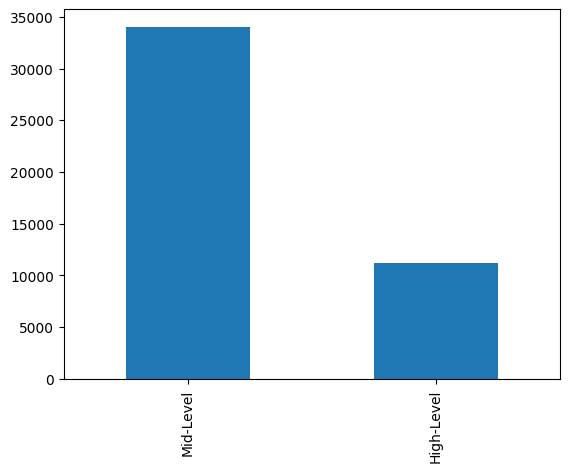

In [15]:
## histogram of income distribution

income_counts = census['income'].value_counts()

print(census['income'].value_counts())

income_counts.plot.bar()

plt.show()

In [16]:
## calculating proportion of midlevel donors
count_mid = (census['income'] == 'Mid-Level').sum()

prop_mid = count_mid / len(census['income'])

round(prop_mid,2)

0.75

This dataset appears to be constructed with 75% of individuals being classified under the Mid-Level donor definition. This means that the target class of High-Level will be a minority class in this analysis and that there is a class imbalance that must be considered for this analysis.

#### Workclass

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


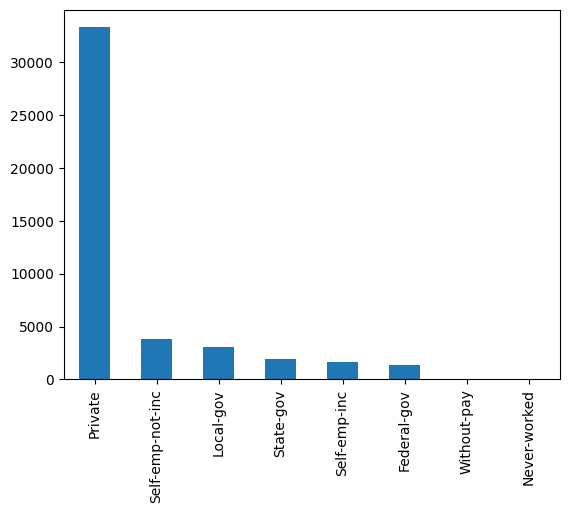

In [17]:
## histogram of workclass distribution
workclass_counts = census['workclass'].value_counts()

print(census['workclass'].value_counts())

workclass_counts.plot.bar()

plt.show()

In [18]:
## finding workclass proportions
count_priv = (census['workclass'] == 'Private').sum()

count_priv

prop_priv = count_priv / len(census['workclass'])

round(prop_priv,2)

0.74

About 74% of individuals in this analysis work as part of the private sector again showing another class imbalance. There also appears to be many different categories of work class that are fairly similar (government jobs, not currently working, etc) which can probably be combined together.

#### Marital Status

Married-civ-spouse       21056
Never-married            14605
Divorced                  6298
Separated                 1411
Widowed                   1277
Married-spouse-absent      553
Married-AF-spouse           32
Name: marital-status, dtype: int64


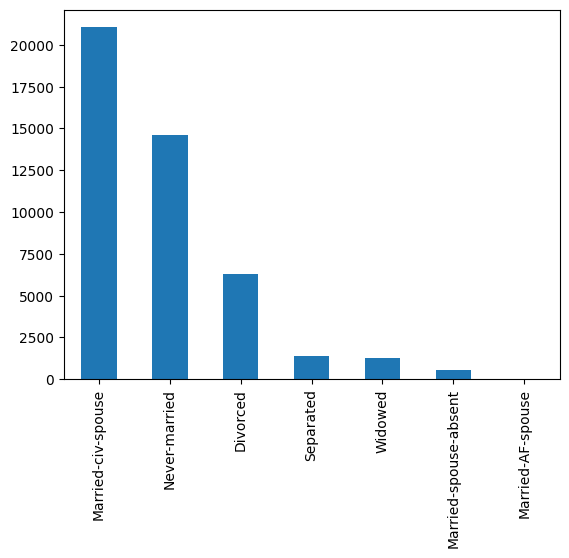

In [19]:
## histogram of marital status distribution
counts = census['marital-status'].value_counts()

print(census['marital-status'].value_counts())

counts.plot.bar()

plt.show()

Similar to working class, marital status appears to have many categories that can be combined. As is, married with a civilian spouse seems to be the largest class.

#### Sex

Male      30534
Female    14698
Name: sex, dtype: int64


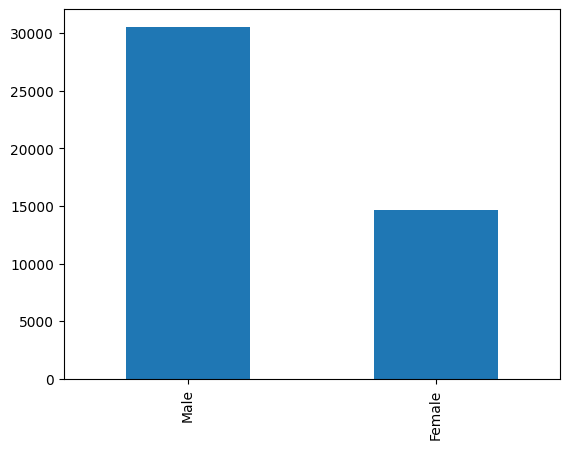

In [20]:
## histogram of sex distribution

counts = census['sex'].value_counts()

print(census['sex'].value_counts())

counts.plot.bar()

plt.show()

In [21]:
## proportion of male sex
count = (census['sex'] == 'Male').sum()

prop = count / len(census['sex'])

round(prop,2)

0.68

68% of individuals in this dataset are Male which shows another class imbalance as it comes to the sex of individuas in this dataset.

#### Native Country

In [22]:
## proportion of US natives
count = (census['native-country'] == 'United-States').sum()

prop = count / len(census['native-country'])

round(prop,2)

0.91

There are many different native countries for individuals in this dataset but the vast majority of individuals are from the United States compromising 91% of individuals in the dataset.

### Bivariate Analysis

<AxesSubplot: xlabel='sex', ylabel='count'>

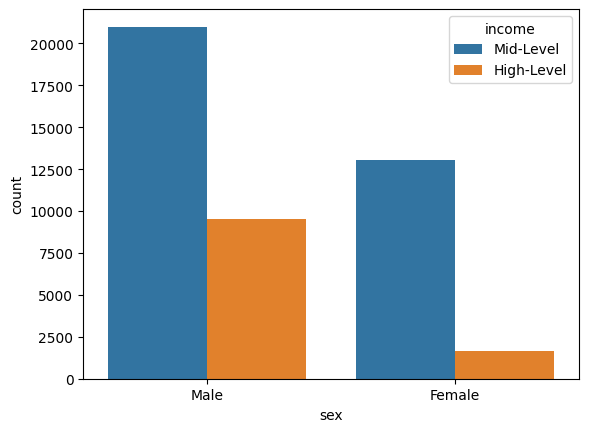

In [23]:
## Display income by sex
sns.countplot(x='sex', hue='income', data = census)

There appears to be a larger difference in the ratio of high level to mid level individuals for females than there are for males.

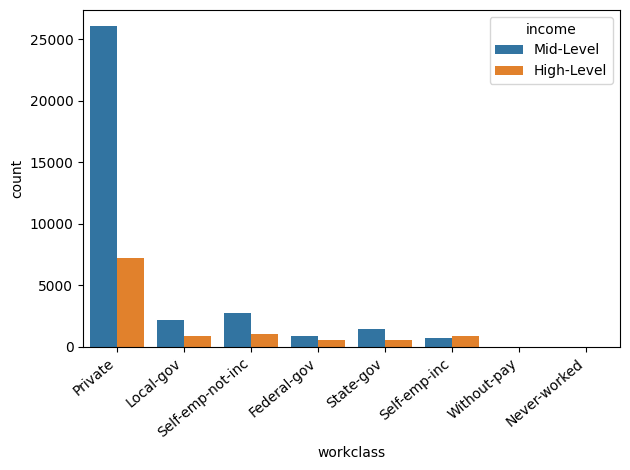

In [24]:
## Display income by workclass

ax = sns.countplot(x='workclass' , hue='income', data = census)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

The self employed work class is the only workclass where there are more high level individuals than there are mid level.

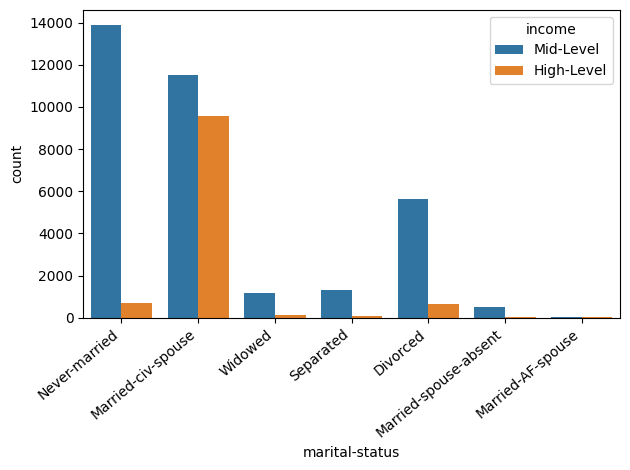

In [25]:
## Display Marital Status by Income

ax = sns.countplot(x='marital-status' , hue='income', data = census)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

The married with a civilian spouse marital status class has almost as many high-level individuals as mid level individuals. The other classes have dramatically higher disparities.

## Pre-processing

### Normalization and Standardization of Categorical Variables
Comibining similar classes in the categorical features that will be used for the analysis in order to make the results more interpretable.

#### Marital-Status

Combining the rows in the marial-status of Married-civ-spouse, Married-spouse-absent, and Married-AF-spouse to Married

In [26]:
## find counts of values for marital status
census['marital-status'].value_counts()

Married-civ-spouse       21056
Never-married            14605
Divorced                  6298
Separated                 1411
Widowed                   1277
Married-spouse-absent      553
Married-AF-spouse           32
Name: marital-status, dtype: int64

In [27]:
## find counts of values for marital status after initial consolidation
census['marital-status'] = census['marital-status'].replace({'Married-civ-spouse': 'Married', 
                                  'Married-spouse-absent': 'Married', 
                                  'Married-AF-spouse': 'Married'})
census['marital-status'].value_counts()

Married          21641
Never-married    14605
Divorced          6298
Separated         1411
Widowed           1277
Name: marital-status, dtype: int64

In [28]:
## find counts of values for marital status after final consolidation
census['marital-status'] = census['marital-status'].replace({'Never-married': 'Single', 
                                  'Divorced': 'Single','Separated': 'Single', 'Widowed': 'Single'})
census['marital-status'].value_counts()

Single     23591
Married    21641
Name: marital-status, dtype: int64

We only have two marital status classes which are very similar in frequency in this dataset.

#### Workclass

In [29]:
## find counts of values for workclass
census['workclass'].value_counts()

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [30]:
## find counts of values for workclass after consolidation
census['workclass'] = census['workclass'].replace({'Local-gov': 'Government', 
                                                   'Federal-gov': 'Government', 
                                                   'State-gov': 'Government',
                                                   
                                                   'Self-emp-not-inc': 'Self-emp',
                                                   'Self-emp-inc': 'Self-emp',
                                                   
                                                   'Without-pay': 'No-income',
                                                   'Never-worked': 'No-income',
                                                   
                                                   '?': 'Unknown'})

census['workclass'].value_counts()

Private       33307
Government     6452
Self-emp       5442
No-income        31
Name: workclass, dtype: int64

With data preparation, the number of classes within workclass was able to be simplified to only 4 classes with Private still being the largest work class.

#### Native Country

In [31]:
## find counts of values for native country after final consolidation
census['native-country'] = np.where((census['native-country'] != 'United-States') & 
                                    (census['native-country'] != '?'), 'Non-US', census['native-country'])

census['native-country'] = census['native-country'].replace({'?': 'Unknown'})

census['native-country'].value_counts()

United-States    41302
Non-US            3930
Name: native-country, dtype: int64

As the list of different native countries was extremely long but with the United States being the Native Country for the vast majority of individuals, all non-US countries were grouped together to simplify the number of classes.

#### Education

In [32]:
## find counts of values for education
census['education'].value_counts()

HS-grad         14785
Some-college     9901
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1622
Assoc-acdm       1507
10th             1225
7th-8th           824
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: education, dtype: int64

In [33]:
## find counts of values for education after final consolidation
census['education'] = census['education'].replace({'10th': 'DNF HS', 
                                                   '7th-8th': 'DNF HS', 
                                                   '9th': 'DNF HS',
                                                   '11th': 'DNF HS', 
                                                   '9th': 'DNF HS',
                                                   '12th': 'DNF HS', 
                                                   '5th-6th': 'DNF HS',
                                                   '1st-4th': 'DNF HS', 
                                                   'Preschool': 'DNF HS',
                                                  
                                                   'HS-grad': 'HS',
                                                   'Some-college': 'HS',
                                                   
                                                   'Assoc-voc': 'Assoc',
                                                   'Assoc-acdm': 'Assoc'})

census['education'].value_counts()

HS             24686
Bachelors       7570
DNF HS          5667
Assoc           3466
Masters         2514
Prof-school      785
Doctorate        544
Name: education, dtype: int64

The number of education categories in the original dataset was very long and difficult to interpret. To solve for this, we grouped together all the education categories that did not finish high school into DNF HS (Did not finish High School), as we grouped together all individuals who finished high school but not college, and those that completed an associate's degree.

### One Hot Encoding
Most classification models require that categorical features be hot encoded with a numerical value.

In [34]:
## saving a new dataframe with one hot encoding for categorical features
census_encoded = pd.get_dummies(data=census, columns=['workclass', 'education', 'marital-status', 'sex',
                                                     'native-country'])

In [35]:
## display features after encoding
census_encoded.columns

Index(['age', 'income', 'workclass_Government', 'workclass_No-income',
       'workclass_Private', 'workclass_Self-emp', 'education_Assoc',
       'education_Bachelors', 'education_DNF HS', 'education_Doctorate',
       'education_HS', 'education_Masters', 'education_Prof-school',
       'marital-status_Married', 'marital-status_Single', 'sex_Female',
       'sex_Male', 'native-country_Non-US', 'native-country_United-States'],
      dtype='object')

In [36]:
## must remove one encoded column to avoid multicollinearity due to dummy variable trap
census_encoded = census_encoded.drop(columns=['workclass_Private', 'education_HS', 
                                             'marital-status_Single', 'sex_Male',
                                             'native-country_United-States'])

In [37]:
## display dataset after encoding
census_encoded.head(5)

,age,income,workclass_Government,workclass_No-income,workclass_Self-emp,education_Assoc,education_Bachelors,education_DNF HS,education_Doctorate,education_Masters,education_Prof-school,marital-status_Married,sex_Female,native-country_Non-US
0,25,Mid-Level,0,0,0,0,0,1,0,0,0,0,0,0
1,38,Mid-Level,0,0,0,0,0,0,0,0,0,1,0,0
2,28,High-Level,1,0,0,1,0,0,0,0,0,1,0,0
3,44,High-Level,0,0,0,0,0,0,0,0,0,1,0,0
5,34,Mid-Level,0,0,0,0,0,1,0,0,0,0,0,0


## Modeling and Evaluation

### Train/ Test Split

In [38]:
## Train/Split with 20% witheld for testing
train, test = train_test_split(census_encoded, test_size=0.2, random_state=42, stratify=census_encoded['income'])

## Used for column headers
census_X = census_encoded.drop(columns=['income'])

X_train = train.drop(columns=['income'])
X_test = test.drop(columns=['income'])

y_train = train['income']
y_test = test['income']

In [39]:
## Target Variable Classes
classes = ['High-Level', 'Mid-Level']

In [40]:
## print shape of train and test sets
print('Shape of training features:', X_train.shape)
print('Shape of testing features:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training features: (36185, 13)
Shape of testing features: (9047, 13)
Shape of training label: (36185,)
Shape of training label: (9047,)


### Model Training and Hyperparameter Training

#### Logistic Regression

In [41]:
## Hyperparameter Tuning for LR

# define models and parameters
model = LogisticRegression(max_iter = 10000000)

# hyperparameters
solvers = ['newton-cg', 'lbfgs', 'liblinear'] ## default lbfgs
penalty = ['l2'] ## default l2

# define grid search
grid = dict(solver=solvers,penalty=penalty)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.810695 using {'penalty': 'l2', 'solver': 'liblinear'}
0.810667 (0.004762) with: {'penalty': 'l2', 'solver': 'newton-cg'}
0.810557 (0.004630) with: {'penalty': 'l2', 'solver': 'lbfgs'}
0.810695 (0.004661) with: {'penalty': 'l2', 'solver': 'liblinear'}


In [42]:
## Save Logistic Regression Model with best hyperparamter performance
logit_regCV = LogisticRegressionCV(solver='liblinear', penalty='l2')
logit_regCV.fit(X_train, y_train)

LogisticRegressionCV(solver='liblinear')

#### Decision Tree

In [43]:
# define models and parameters for Decision Tree
model = tree.DecisionTreeClassifier(random_state=1)

# hyperparameters
criterion = ['gini', 'entropy'] ## default gini
max_depth = [None, 5, 10, 20] ## default None
min_split = [2,5,10] ## default 2

# define grid search
grid = dict(criterion=criterion, max_depth=max_depth, min_samples_split=min_split)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.816416 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
0.799889 (0.005314) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
0.800801 (0.004846) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5}
0.802846 (0.004429) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10}
0.801879 (0.006852) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
0.801879 (0.006852) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}
0.801879 (0.006852) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}
0.816029 (0.005709) with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
0.816084 (0.005596) with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
0.816416 (0.005678) with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
0.800691 (0.004496) with: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}
0.801327 (0.004252)

In [44]:
## Save Decition Tree model with best hyperparamter performance
dtc = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 10, min_samples_split = 10, random_state=1)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=1)

#### Random Forest

(n_estimators) and the number of features considered for splitting at each leaf node (max_features)

In [ ]:
# define models and parameters and Random Forest
model = RandomForestClassifier(random_state=1)

# hyperparameters
criterion = ['gini', 'entropy'] ## default gini
n_estimators = [100, 200, 300] ## default 100
max_features = ['sqrt', 'log2', None] ## default sqrt


# define grid search
grid = dict(criterion = criterion, n_estimators=n_estimators, max_features=max_features)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Building Random Forest model with best performing hyperparameters
rf = RandomForestClassifier(criterion = 'entropy', max_features = None, n_estimators = 100, random_state=1)
rf.fit(X_train, y_train)

#### Naive Bayes

In [ ]:
# define models and parameters for Naive Bayes
model = GaussianNB()

# hyperparameters
var_smoothing = [0.00000001, 0.000000001, 0.0000000001] ## default 1e-9


# define grid search
grid = dict(var_smoothing = var_smoothing)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Building Naive Bayes model with best performing hyperparameters
nb = GaussianNB(var_smoothing =1e-08)
nb.fit(X_train, y_train)

#### KNN

In [ ]:
## build model for KNN
model = KNeighborsClassifier()

n_neighbors =[5, 7] ## default 5
weights = ['uniform', 'distance'] # default uniform
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'] ## default auto

# define grid search
grid = dict(n_neighbors = n_neighbors, weights = weights, algorithm = algorithm)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Building KNN model 
knn = KNeighborsClassifier(algorithm = 'brute', n_neighbors = 7, weights = 'uniform')
knn.fit(X_train, y_train)

In [ ]:
## function to calculate performance metrics
def evaluate_model(model, in_xtest, in_ytest):
    from sklearn import metrics

    # Test Data prediction 
    local_ypred = model.predict(in_xtest)

    # calculating accuracy, precision, recall, f1-score, and kappa score
    accuracy = round(metrics.accuracy_score(in_ytest, local_ypred),2)
    precision = round(metrics.precision_score(in_ytest, local_ypred, pos_label='High-Level'),2)
    recall = round(metrics.recall_score(in_ytest, local_ypred, pos_label='High-Level'),2)
    f1 = round(metrics.f1_score(in_ytest, local_ypred, pos_label='High-Level'),2)
    kappa = round(metrics.cohen_kappa_score(in_ytest, local_ypred),2)
    
    
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'f1': f1, 'Kappa': kappa}

In [ ]:
## Logistic Regression Results
log_metric = evaluate_model(logit_regCV, X_test, y_test)
log_metric

In [ ]:
## Decision Tree Results
dtc_metric = evaluate_model(dtc, X_test, y_test)
dtc_metric

In [ ]:
## Random Forest Results
rf_metric = evaluate_model(rf, X_test, y_test)
rf_metric

In [ ]:
## Naive Bayes Results
nb_metric = evaluate_model(nb, X_test, y_test)
nb_metric

In [ ]:
## K Nearest Neighbor Results
knn_metric = evaluate_model(knn, X_test, y_test)
knn_metric

In [ ]:
## Visualize all performance measures together
performance = pd.DataFrame({'Logit':pd.Series(log_metric),'Decision Tree':pd.Series(dtc_metric),
                           'Random Forest':pd.Series(rf_metric),'Naive Bayes':pd.Series(nb_metric),
                           'K Nearest Neighbor':pd.Series(knn_metric)})

performance = performance.T

print("Model Performance")
print(performance)

In [ ]:
#### Model Evaluation Visual

In [ ]:
fig, (ax1) = plt.subplots(1)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)


barWidth = 0.1
log_score = [log_metric['Accuracy'], log_metric['Precision'], log_metric['Recall'], log_metric['f1'], log_metric['Kappa']]
dtc_score = [dtc_metric['Accuracy'], dtc_metric['Precision'], dtc_metric['Recall'], dtc_metric['f1'], dtc_metric['Kappa']]
rf_score = [rf_metric['Accuracy'], rf_metric['Precision'], rf_metric['Recall'], rf_metric['f1'], rf_metric['Kappa']]
nb_score = [nb_metric['Accuracy'], nb_metric['Precision'], nb_metric['Recall'], nb_metric['f1'], nb_metric['Kappa']]
knn_score = [knn_metric['Accuracy'], knn_metric['Precision'], knn_metric['Recall'], knn_metric['f1'], knn_metric['Kappa']]

r1 = np.arange(len(log_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]


ax1.bar(r1, log_score, width=barWidth, edgecolor='white', label='Logistic Regression')
ax1.bar(r2, dtc_score, width=barWidth, edgecolor='white', label='Desicion Tree')
ax1.bar(r3, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r4, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r5, knn_score, width=barWidth, edgecolor='white', label='K Nearest Neighbor')


## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Metric_Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

plt.show()